<br/>

$$ \huge{\underline{\textbf{ REINFORCE }}} $$

<br/>

<center>Implementation of <b>REINFORCE</b> algorithm</center>
<center>from Sutton and Barto 2018, <b>chapter 13.3</b>.</center>
<center>Book available for free <a href="http://incompleteideas.net/book/the-book-2nd.html">here</a></center>

<br/>

<img src="assets/1303_REINFORCE.png"/>
<center> From Sutton and Barto (2018) _Reinforcement Learning: An Introduction_, chapter 13.3 </center>

<br/>

<span style="color: red">TODO: rewrite</span>

Differences from the box (see [chapter 9.3](0903a_Gradient_MC.ipynb) for explicit implementation example):
* $\hat{q}$ is a black box trainable function approximator, benefits:
  * avoid explicitly passing around $\mathbf{w}$ - which can be quite complicated structure in some cases (e.g. neural net)
  * avoid computing and stroing $\nabla\hat{q}(S,A,\mathbf{w})$ explicitly - which also can be complicated structure
* don't initialize $\mathbf{w}$ - one we don't know structure of $\mathbf{w}$, two maybe user want's to continue training
* add callback and trace params, so we can track what is going on

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class BanditEnv:
    def __init__(self):
        """10-armed testbed, see chapter 2.3"""
        self.nb_states = 1
        self.nb_actions = 10    # 10 arms
        self.means = np.array([0.25, -0.75, 1.5, 0.5, 1.25,   # eyeball fig 2.1
                               -1.5, -0.25, -1, 0.75, -0.5])
    
    def reset(self):
        return 0  # observation
        
    def step(self, action):
        # observation, reward, done, extra
        return 0, np.random.normal(loc=self.means[action]), True, None

In [3]:
class CorridorSwitchedEnv:
    def __init__(self, max_len=None):
        self.nb_states = 1
        self.nb_actions = 2
        self._state = 0
        self._curr_iter = 0
        
    def reset(self):
        self._state = 0
        self._curr_iter = 0
        return 0    # states are indistinguisable
    
    def step(self, action):
        assert action in [0, 1]  # left, right
        
        if self._state == 0:
            if action == 1:
                self._state = 1
        elif self._state == 1:
            if action == 0:  # left, swapped to right
                self._state = 2
            else:            # right, swapped to left
                self._state = 0
        elif self._state == 2:
            if action == 0:
                self._state = 1
            else:
                self._state = 3  # terminal
        else:
            raise ValueError('Invalid state:', self._state)
        
        # Terminate at time step = 1000
        # sometimes policy becomes deterministic
        # and episodes run into infinity
        self._curr_iter += 1
        if self._curr_iter >= 1000:
            self._state = 3
        
        if self._state == 3:
            return 0, -1, True, None  # obs, reward, done, extra
        else:
            return 0, -1, False, None

In [4]:
def softmax(x):
    """Numerically stable softmax"""
    ex = np.exp(x - np.max(x))
    return ex / np.sum(ex)

In [5]:
class TabularSoftmaxPolicy:
    """Tabular action-state function 'approximator'"""
    def __init__(self, alpha, nb_states, nb_actions, init_theta=None):
        self._alpha = alpha                             # learning rate
        self._nb_states = nb_states
        self._nb_actions = nb_actions
        self._theta = np.zeros(nb_states * nb_actions)  # weights
        if init_theta is not None:
            assert init_theta.dtype == np.float64
            assert init_theta.shape == self._theta.shape
            self._theta = init_theta
    
    def x(self, state, action):
        """Feature vecotr, in our case just one-hot encode"""
        xx = np.zeros(self._nb_states * self._nb_actions)  # construct x(s,a)
        xx[state*self._nb_actions + action] = 1            # one-hot encode
        return xx
        
    def h(self, state, action):
        """Calculate preference h(s,a,theta), see e.q. 13.3"""
        return self._theta @ self.x(state, action)      # scalar, e.q. 13.3
    
    def pi(self, state):
        
        # Option 1: as described in the book
        # construct vector x(s,a) for each action
        # perform full linear combination (e.q. 13.3)
#         h_vec = [self.h(state, b)
#                  for b in range(self._nb_actions)]   # shape=[n_act]
        
        # Option 2: optimized
        # h(state, action) == self._theta[state * self._nb_actions + action]
        # which leads to simplified expression below
        h_vec_2 = self._theta[state*self._nb_actions:state*self._nb_actions+self._nb_actions]
#         assert np.alltrue(h_vec == h_vec_2)
        
        prob_vec = softmax(h_vec_2)                     # shape=[n_act], e.q. 13.2
        
        return prob_vec


    def update(self, state, action, disc_return):
        # Option 1: as described in the book
#         prob_vec = self.pi(state)                   # shape=[n_act]
#         sum_b = [prob_vec[b]*self.x(state,b)        # shape=[n_s*n_a]
#                  for b in range(self._nb_actions)]
#         sum_b = np.sum(sum_b, axis=0)
#         grad_ln_pi = self.x(state, action) - sum_b  # shape=[n_s*n_a], e.q. 13.9
        
        # Option 2: Optimized
        x_s = np.zeros(self._nb_actions)
        x_s[action] = 1
        prob = self.pi(state)
        grad_s = x_s - prob
        
        grad_ln_pi_2 = np.zeros(self._nb_states * self._nb_actions)
        grad_ln_pi_2[state*self._nb_actions:state*self._nb_actions+self._nb_actions] = grad_s
#         assert np.alltrue(grad_ln_pi == grad_ln_pi_2)
        
        self._theta += self._alpha * disc_return * grad_ln_pi_2  # e.q. 13.8

In [6]:
def basic_test(env, ep, alpha):
    
    pi = TabularSoftmaxPolicy(alpha=alpha, nb_states=env.nb_states, nb_actions=env.nb_actions)

    hist_R = []
    hist_prob = []
    
    for i in range(ep):
        _ = env.reset()
        
        prob = pi.pi(state=0)
    #     prob = prob + 1e-2
    #     prob = prob / prob.sum()
    #     prob.sum()
        A = np.random.choice(range(env.nb_actions), p=prob)
        
        _, R, _, _ = env.step(A)
        
        _ = np.random.choice(range(env.nb_actions), p=prob)  # dummy
        
        pi.update(state=0, action=A, disc_return=R)

        hist_R.append(R)
        hist_prob.append(prob)

    hist_R = np.array(hist_R)
    hist_prob = np.array(hist_prob)
    
    return hist_R, hist_prob

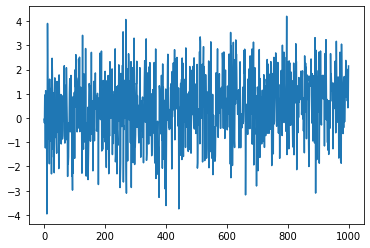

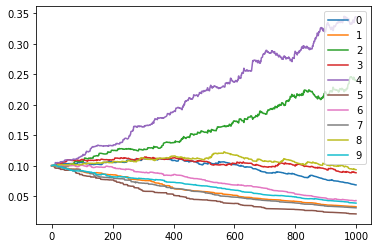

In [7]:
env = BanditEnv()

np.random.seed(4)

hist_R, hist_prob = basic_test(env, ep=1000, alpha=1e-2)

plt.plot(hist_R)
plt.show()
for i in range(env.nb_actions):
    plt.plot(hist_prob[:,i], label=i)
plt.legend()
plt.show()

In [8]:
def generate_episode(env, policy, *params):
    """Generete one complete episode.
    
    Returns:
        trajectory: list of tuples [(st, rew, done, act), (...), (...)],
                    where St can be e.g tuple of ints or anything really
        T: index of terminal state, NOT length of trajectory
    """
    trajectory = []
    done = True
    while True:
        # === time step starts here ===
        if done:  St, Rt, done    = env.reset(), None, False
        else:     St, Rt, done, _ = env.step(At)
        At = policy(St, *params)        
        trajectory.append((St, Rt, done, At))
        if done:  break
        # === time step ends here ===
    return trajectory, len(trajectory)-1

In [9]:
def REINFORCE(env, ep, gamma, alpha, init_theta=None, clip=0.0):
    def policy(st, pi):
        prob = pi.pi(st)
        
        if clip != 0.0:
            prob = np.clip(prob, clip, 1-clip)
            prob /= prob.sum()
        
#         prob = prob + 0.01
#         prob = prob / prob.sum()
#         prob.sum()
        min_ = np.argmin(prob)
#         if prob[min_] < 0.05:
#             prob = [0.95, 0.95]
#             prob[min_] = 0.05
            
        return np.random.choice(range(env.nb_actions), p=prob)

    hist_prob = []
    hist_G_0 = []
    pi = TabularSoftmaxPolicy(alpha=alpha, nb_states=env.nb_states, nb_actions=env.nb_actions, init_theta=init_theta)

    for e_ in range(ep):
        # print(e_)
        traj, T = generate_episode(env, policy, pi)
        
        R_sum = 0
        for t in range(0, T):
            St, Rt, _, At = traj[t]      # (st, rew, done, act)
            Gt = sum([gamma**(k-t-1) * traj[k][1] for k in range(t+1, T+1)])    # <- this is inefficient
            pi.update(St, At, gamma**t * Gt)
            R_sum += 0 if Rt is None else Rt
        hist_prob.append(pi.pi(St))
        hist_G_0.append(R_sum)
        
        
#         Gt = 0
#         for t in range(T-1,-1,-1):
#             St, _, _, At = traj[t]      # (st, rew, done, act)
#             _, Rt_1, _, _ = traj[t+1]
#             Gt = gamma * Gt + Rt_1
#             pi.update(St, At, Gt)
#             prob = pi.pi(St)
#         hist_prob.append(prob)
#         hist_G_0.append(Gt)

    hist_prob = np.array(hist_prob)
    hist_G_0 = np.array(hist_G_0)
    
    return hist_G_0, hist_prob

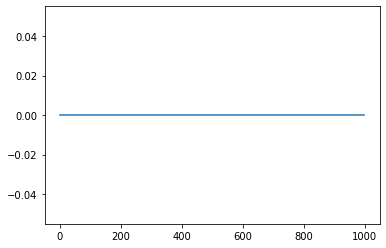

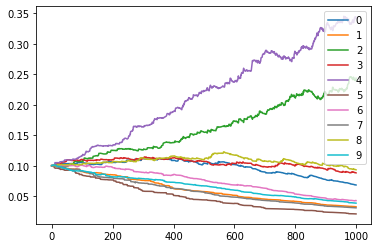

In [10]:
env = BanditEnv()

np.random.seed(4)

hist_R, hist_prob = REINFORCE(env, ep=1000, gamma=1.0, alpha=1e-2)

plt.plot(hist_R)
plt.show()

for i in range(env.nb_actions):
    plt.plot(hist_prob[:,i], label=i)
plt.legend()
plt.show()

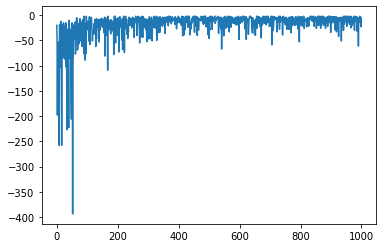

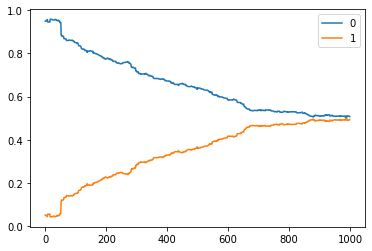

In [11]:
# np.random.seed()
# rr = np.random.randint(0, 1e9)
# print(rr)
# np.random.seed(rr)

# np.random.seed(719241581); alpha = 2**-9

np.random.seed(0)

max_len = None
alpha = 2**-13

env = CorridorSwitchedEnv(max_len=max_len)

hist_R, hist_prob = REINFORCE(env, ep=1000, gamma=1.0, alpha=alpha, init_theta=np.array([1.47, -1.47]))

plt.plot(hist_R)
plt.show()

for i in range(env.nb_actions):
    plt.plot(hist_prob[:,i], label=i)
plt.legend()
plt.show()

In [12]:
np.random.seed(1)

env = CorridorSwitchedEnv()

runs_a13 = []

for i in range(100):
    hist_R, hist_prob = REINFORCE(env, ep=50, gamma=1.0, alpha=2**-13, init_theta=np.array([1.47, -1.47]))
    runs_a13.append(hist_R)
    
    if (i+1) % 10 == 0: print(i+1)

runs_a13 = np.array(runs_a13)

10
20
30
40
50
60
70
80
90
100


In [13]:
runs_a13_avg = np.average(runs_a13, axis=0)

(0, 1000)

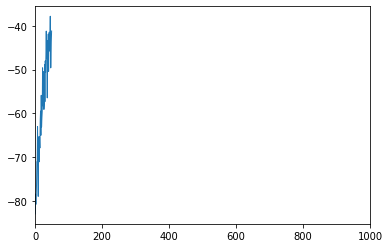

In [14]:
plt.plot(runs_a13_avg, linewidth=1.0)
plt.xlim(0,1000)

# Recreate figure 13.1

In [15]:
import multiprocessing as mp

In [16]:
def run_single_experiment(alpha, max_len, clip):
    np.random.seed()  # required due to multiprocessing
    env = CorridorSwitchedEnv(max_len)
    hist_R, _ = REINFORCE(env, ep=1000, gamma=1.0, alpha=alpha, init_theta=np.array([1.47, -1.47]), clip=clip)
    return hist_R

In [17]:
def run_multiple_exp(repeat, params):
    with mp.Pool(processes=mp.cpu_count()-2) as pool:
        param_list = [params] * repeat
        results = pool.starmap(run_single_experiment, param_list)
        results = np.array(results)         # shape [nb_repeat, nb_episodes]
        return np.average(results, axis=0)  # shape [nb_episodes]

In [18]:
runs_a12_avg = run_multiple_exp(repeat=100, params=(2**-12, 1000, 0.0) )

In [19]:
runs_a13_avg = run_multiple_exp(repeat=100, params=(2**-13, 1000, 0.0) )

In [20]:
runs_a14_avg = run_multiple_exp(repeat=100, params=(2**-14, 1000, 0.0) )

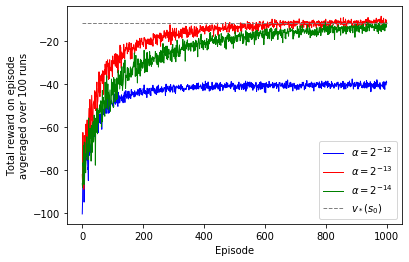

In [38]:
plt.plot(runs_a12_avg, linewidth=1.0, color='blue', label='$\\alpha = 2^{-12}$')
plt.plot(runs_a13_avg, linewidth=1.0, color='red', label='$\\alpha = 2^{-13}$')
plt.plot(runs_a14_avg, linewidth=1.0, color='green', label='$\\alpha = 2^{-14}$')
plt.plot([-11.6]*1000, linewidth=1.0, linestyle='--', color='gray', label='$v_*(s_0)$')
plt.ylabel('Total reward on episode\navgeraged over 100 runs')
plt.xlabel('Episode')
plt.legend()
plt.show()

In [39]:
np.savez('arrs.npz', {'runs_a12_avg':runs_a12_avg, 'runs_a13_avg':runs_a13_avg, 'runs_a14_avg':runs_a14_avg})